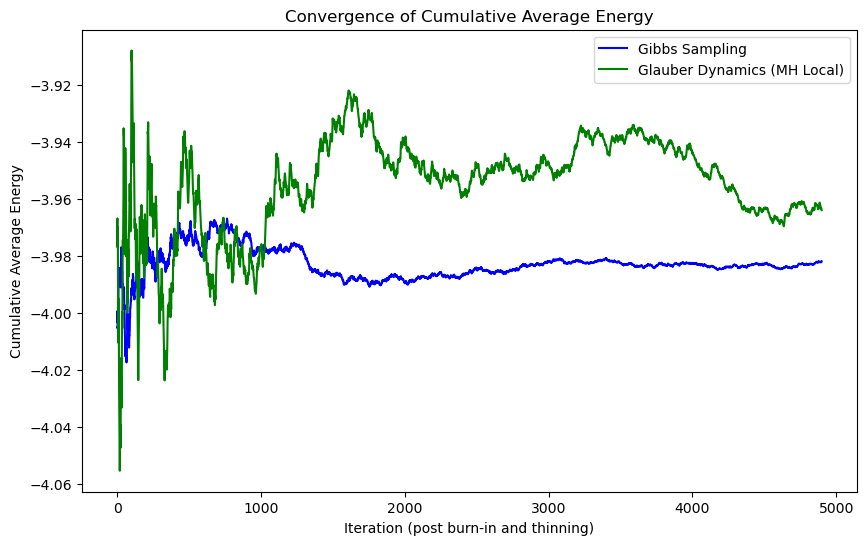

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Hyperparameters for the RBM and MCMC sampling
d = 5           # Number of visible units (toy RBM)
m = 4           # Number of hidden units (toy RBM)
num_steps = 50000    # Total number of iterations
burn_in = 1000      # Burn-in period: number of initial iterations to discard
thinning = 10       # Thinning interval: output every 'thinning' sample

# Initialize RBM parameters with moderate biases to encourage mixing
W = 0.3 + torch.randn(d, m) * 0.1  # Weight matrix (d x m)
b = -1 + torch.randn(d) * 0.1      # Visible bias (d,)
c = 1 + torch.randn(m) * 0.1       # Hidden bias (m,)

def energy(v, h):
    """Compute the energy of configuration (v, h)."""
    return - (torch.dot(b, v) + torch.dot(c, h) + torch.dot(v, torch.matmul(W, h)))

def sample_hidden(v):
    """Sample hidden units given visible units using conditional probabilities."""
    p_h = torch.sigmoid(torch.matmul(v, W) + c)
    return (torch.rand(m) < p_h).float()

def sample_visible(h):
    """Sample visible units given hidden units using conditional probabilities."""
    p_v = torch.sigmoid(torch.matmul(W, h) + b)
    return (torch.rand(d) < p_v).float()

###############################################################################
# Gibbs Sampler: Alternating conditional sampling.
###############################################################################
def gibbs_sampler(num_steps, initial_v):
    v = initial_v.clone()
    cumulative_energy = []
    energy_sum = 0.0
    for i in range(num_steps):
        h = sample_hidden(v)
        v = sample_visible(h)
        # Compute instantaneous energy using a fresh hidden sample
        E = energy(v, sample_hidden(v)).item()
        energy_sum += E
        cumulative_energy.append(energy_sum / (i + 1))
    return np.array(cumulative_energy)

###############################################################################
# Local Metropolis--Hastings Sampler (Glauber Dynamics):
# Propose to flip one randomly chosen spin (visible or hidden) at a time.
###############################################################################
def mh_sampler_local(num_steps, initial_state):
    v, h = initial_state
    cumulative_energy = []
    energy_sum = 0.0
    for i in range(num_steps):
        if np.random.rand() < 0.5:
            # Propose flipping one visible unit
            idx = np.random.randint(d)
            v_prop = v.clone()
            v_prop[idx] = 1 - v_prop[idx]
            delta_E = energy(v_prop, h) - energy(v, h)
            alpha = min(1, torch.exp(-delta_E).item())
            if torch.rand(1) < alpha:
                v = v_prop
        else:
            # Propose flipping one hidden unit
            idx = np.random.randint(m)
            h_prop = h.clone()
            h_prop[idx] = 1 - h_prop[idx]
            delta_E = energy(v, h_prop) - energy(v, h)
            alpha = min(1, torch.exp(-delta_E).item())
            if torch.rand(1) < alpha:
                h = h_prop
        E = energy(v, h).item()
        energy_sum += E
        cumulative_energy.append(energy_sum / (i + 1))
    return np.array(cumulative_energy)

###############################################################################
# Run the samplers and plot cumulative average energy on the same plot.
###############################################################################
# Initialize the RBM state randomly
initial_v = (torch.rand(d) < 0.5).float()
initial_h = (torch.rand(m) < 0.5).float()

gibbs_cum_energy = gibbs_sampler(num_steps, initial_v)
mh_cum_energy = mh_sampler_local(num_steps, (initial_v, initial_h))

# Process the metrics: discard burn-in and apply thinning
def process_metric(metric):
    return metric[burn_in:][::thinning]

gibbs_metric = process_metric(gibbs_cum_energy)
mh_metric = process_metric(mh_cum_energy)

# Plot cumulative average energy for both samplers on the same plot
plt.figure(figsize=(10, 6))
plt.plot(gibbs_metric, label='Gibbs Sampling', color='blue')
plt.plot(mh_metric, label='Glauber Dynamics (MH Local)', color='green')
plt.xlabel('Iteration (post burn-in and thinning)')
plt.ylabel('Cumulative Average Energy')
plt.title('Convergence of Cumulative Average Energy')
plt.legend()
plt.show()